In [1]:
import numpy as np
import pandas as pd
from MotifExtraction import *
from Network import *
from Preprocessing import *
from TrainAndTest import *

### Introduction & Motivation:

Subcellular location is a major factor in determining function, evolution, and importance for many proteins across the animal kingdom. Multicellular life generally transcribes and translates proteins from DNA and RNA around the nucleus involving ribosomes. However, most proteins around the cell do not operate around the nucleus or in the region where they were translated. Instead, these protein strands are targeted and shepherded around the cell, crossing cellular membranes in order to be localized at their final destinations (mitochondria, chloroplasts, lysosomes, vacuoles, etc). Because proteins that are localized to specific subcellular compartments often share in a common purpose, they also share in a common evolution. Simply knowing where a protein operates gives researchers a great deal of information about that protein’s purpose and potentially a shared evolutionary history with other proteins. Before the rise of machine learning classifiers, protein localization assays were often a first step in studying any particular gene in any given model organism. Localization assays often involved tagging the protein with GFP (Green Fluorescent Protein) and using confocal microscopy to determine location. This, however, does have some drawbacks. The first is that it is obviously manual work and could not be automated. The gene in question would have to be spliced with GFP and then the model organism grown, harvested, and sectioned for microscopy; A labor intensive task. The second is that GFP is an incredibly large chunk of protein and often could introduce aberrant behavior for the protein in study. GFP could cause the protein to fail to be localized correctly or interfere with the overall protein function / folding. Because proteins often share targeting motifs in their coding regions, this is a ripe area of study for machine learning. Instead of dealing with the hassle of GFP, it is possible to build, train, and use a neural network to identify these motif regions within proteins and classify protein subcellular location at rates impossible to compete with using experimental localization assays. 

### Methods

Because of my previous experience and work in the field of cell biology and biotechnology, this is a project that is incredibly interesting to me, to see if I can build a broad classifier which could identify targeting motifs is hugely exciting. I am also planning on moving into the realm of bioinformatics after graduating and so a project like this gives me ample opportunity to work on projects that may be very similar to the kind of work I’ll be doing in my career. 

The data I intend to use for this work is from Dan Sloan’s lab in the CSU department of Biology. Sloan’s lab has built a targeting database for Arabidopsis thaliana including thousands of genes. The sequences for these genes can be found from Phytozome, an open source genetic library for plants developed by the DoE (Department of Energy). In order to complete this analysis, I will use two convolutional networks, 1D CNN and a 2D CNN. The 2D CNN is taken from Dr. Asa Ben-Hur, who built it off of the Basset framework while the 1D CNN was provided in this class. Part I of this analyses will recapitulate the Basset paper pipeline, but use the Arabidopsis thaliana dataset I acquired from the Sloan lab. This part of the analysis will be to see how well the Basset framework can recognize and pull out targeting motifs, rather than the DNA binding motifs it was originally built to analyze. Part II of this analysis will be a simple classification problem, using the same dataset and a 1D CNN with the idea of being able to predict whether or not a protein is localized either to the mitochondria or the plastid by sequence alone. 

It is worth noting that this is, in part, an extension of a previous machine learning project where the same data was used, but only very simple classifiers were used (Perceptron, RandomForest, SVM, etc). To expand on this project I will be using some of the same approaches used in the previous project, but only as a baseline for exploring how well a neural network manages this classification problem. Almost nothing from the previous project will simply be copy-pasted into this project as many of the algorithms and data management functions have entirely been rewritten to allow for more flexibility. Regardless a baseline notebook will be provided along with the project proposal. 


# Part I


#### Project Sources and Contributions 
This part of the project will focus on motif extraction for both mitochondrially and plastid (chloroplast) located proteins from Arabidopsis thaliana. This pipeline was largely inspired and used from the Basset paper published in 2016 (https://pubmed.ncbi.nlm.nih.gov/27197224/). Many of the function baselines used for this pipeline were built from the Basset code base available here: https://github.com/davek44/Basset and here: https://github.com/MedChaabane/deepRAM. The pipeline was largely built by Ahmed Addaoud, a graduate student of Asa Ben-Hur in the CS department. Further details about which functions were written personally or barrowed can be found in the accompanying python scripts, however it is worth noting that while I personally did not develop the flow of this pipeline I am responsible for its current organization. As part of our 525 project my responsibility was organizing the code base for this pipeline and in doing so I augmented each of these functions such that they could be broken out into different scripts and files. 

### Motif Extraction

Like stated above, this part of the project will use the Basset pipeline in an attempt to find DNA targeting motifs for mitochondrially or plastid located proteins. Originally this pipeline used CHIPseq peak data to find regions of DNA binding and so has been altered slightly for the difference in function and data inputs. 

The general flow of the pipeline is as follows: 
* Define variables used throughout the pipeline
* Import data 
* Preprocess Data and organize it into dataframes
    * Pad and OneHotEncode DNA transcripts
* Split the data into Train, Validate, Test, and Calibrate data sets. 
* Load the data through an imported Dataset Loader. 
* Calibrate the CNN model using hyperparemeter tuning
* Train and Test the best model
* Extract Motifs

#### Setup variables used for the pipeline


In [2]:
global device
global model_dir
global results_dir
global data_dir
global verbose

motif_len = 24

if torch.cuda.is_available():
    device = 'cuda' 
else:
    device = 'cpu'

model_dir = 'model'
results_dir = 'results'
data_dir = 'Data'
verbose = False

#### Data import
The CyMIRA_Target_Only.csv file is an augmented database file provided from Dan Sloan's lab, developed by Evan Forsythe. It is a large database file for Arabidopsis thaliana which includes protein functional information and location. The dataset has been stripped to only include geneIDs and Location. 
The Atha_Tran.fa file is a fasta file downloaded from Phytozome, an open source genomic database for plants. The file in quest contains DNA / nucleotide basepair sequences rather than protein sequences. Often protein sequences are preferred for motif extraction since they are both shorter than DNA (due to 3 nucleotides encoding for a single amino acid. For example, the DNA nucleotide sequence 'CAA' encodes for the single amino acid Glutamine) and depict a coding only region of DNA. However the Basset paper and architecture originally used CHIPseq data which finds peak binding activity of open DNA (DNA available to be transcribed and translated) and specifically uses nucleotide profiles in their neural network. In order to keep as much of the pipeline intact without major rewrite, I have also decided to use a DNA profile for my data as well. 

In [3]:
#Importing the data
dnaTranscripts = pd.read_csv('Atha_Tran.fa', delimiter='\t')
geneLocations = pd.read_csv('CyMIRA_Target_Only.csv', delimiter= ',')\

#Convert to DataFrame for easy manipulation
protTranscripts = pd.DataFrame(dnaTranscripts)

protTranscripts

,>ATCG00500.1 pacid=37375748 polypeptide=ATCG00500.1 locus=ATCG00500 ID=ATCG00500.1.Araport11.447 annot-version=Araport11
0,ATGGAAAAATCGTGGTTCAATTTTATGTTTTCTAAGGGAGAATTGG...
1,TTTTGCTCCTGGTGAAAAGACTACTATAAGTCAAGACCGTTTTATA...
2,AGCGTTCTAGTTATTCTTCTAGTTATTCCAATAATGTTGATCTTTT...
3,GATGACACCTTTTTTGTTAGGGATAGTAATAAGAATAGTTATTCTA...
4,TGACAATGATTTTAGTGACCTAGAAAAATTTTTTTATAGTTATTGT...
...,...
462247,ATGTATATAAAAAGTTATCATATCGATAATAAATATGACATTGTAG...
462248,CATTTGGGCGATACAAGCTTCCTATGGCTTCGGGCATAAGAAGGTT...
462249,TGATAAACACAAAGTCATCTAATCCAAGGCTACAACACTTTCTCGA...
462250,ATAGAATTTTCTTTCAAACATCGAGAGCAGAACGGATGTGCGGATT...


#### Beginning of Data Preprocessing
Here we use several functions built by me to strip, organize, and combine the two data files into a dataframe that contains the GeneID (gene name), GeneLoc (gene location), and GeneSeq (DNA sequence). 

In [4]:
#Filter out unknowns and null values inside DataFrame. Then get specific filtered DataFrames of Mito/Plastid
filteredGenes = getTargetedProteins(geneLocations)
mitoGenes = getMitoProteins(filteredGenes)
plastidGenes = getPlastidProteins(filteredGenes)

#Converts .fa file to a python dictionary with key:value pair (geneID:protSequence)
source_dict = SeqIO.to_dict(SeqIO.parse('Atha_Tran.fa', 'fasta'))

#Merges the arrays of location data and sequence data
plastidData = getPlastidSeqs(plastidGenes, source_dict)
mitoData = getMitoSeqs(mitoGenes, source_dict)

mitoData,plastidData

Protein Localization Data trimmed down to shape: (4268, 3)
Returning DataFrame of Mitochondrial targeted proteins with shape: (1337, 3)
Returning DataFrame of Plastid targeted proteins with shape: (2495, 3)


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(           GeneID       GeneLoc  \
 1     AT1G01170.1  Mitochondria   
 2     AT1G01290.1  Mitochondria   
 3     AT1G01970.1  Mitochondria   
 4     AT1G02160.2  Mitochondria   
 5     AT1G02370.1  Mitochondria   
 ...           ...           ...   
 1333  AT5G66658.1  Mitochondria   
 1334  AT5G66760.1  Mitochondria   
 1335  AT5G66860.1  Mitochondria   
 1336  AT5G67490.1  Mitochondria   
 1337  AT5G67590.1  Mitochondria   
 
                                                 GeneSeq  
 1     (A, T, G, G, C, A, T, C, A, G, G, A, G, G, T, ...  
 2     (A, T, G, A, T, T, T, C, G, A, C, G, C, T, C, ...  
 3     (A, T, G, G, G, A, A, T, T, T, A, T, A, G, C, ...  
 4     (A, T, G, T, C, G, A, C, G, A, A, A, G, G, C, ...  
 5     (A, T, G, A, A, T, T, T, C, C, G, T, A, A, T, ...  
 ...                                                 ...  
 1333  (A, T, G, A, T, T, G, C, T, T, T, C, T, T, C, ...  
 1334  (A, T, G, T, G, G, C, G, C, T, G, C, G, T, C, ...  
 1335  (A, T, G, G, C, G, A, A, A, 

In [5]:
print(mitoData.shape)
print(plastidData.shape)

mitoBalance = mitoData.shape[0] / (plastidData.shape[0] + mitoData.shape[0])
plastidBalance = plastidData.shape[0] / (plastidData.shape[0] + mitoData.shape[0])

dataBalance = (mitoBalance, plastidBalance)
dataBalance

(1337, 3)
(2495, 3)


(0.34890396659707723, 0.6510960334029228)

#### Pad and OneHotEncode DNA transcripts

The first part of this motif extraction phase will focus on Mitochondrially encoded proteins. Here I get a list of the DNA sequences and create a OneHotEncoded vector of that data. The generate_onehot_data function does several things at once. First it takes in the sequence and encodes each nucleotide as a 4 by 1 by X vector where each nucleotide position is maintained and encoded as a 1 in a 4 by 1 matrix. These vectors are then padded to ensure that each sequence is both exactly the same in length and that the scanning window of the CNN used for this analysis doesn't 'run off he edge of the map.' In addition to encoding and padding the data this function does one other important feature which is to generate a negative dataset and encode positive and negative datasets. 

Because the sequence data provided are all positive examples (IE, each sequence *has* a targeting motif which sends it to the subcellular compartment in question) we must generate a negative sequence to show the CNN bad examples as well. To do this, the sequence data set is copied and then each sequence is randomly shuffled and listed as a negative example. Positive and negative examples are encoded as 1's and 0's respectively. 

In [6]:
mitoSeqBioList = mitoData['GeneSeq'].values.tolist()
mitoSeqList = []

for seq in mitoSeqBioList:
    mitoSeqList.append(str(seq[-100:]))

mitoPaddedData = generate_onehot_data(mitoSeqList,motif_len)


In [7]:
plastidSeqBioList = plastidData['GeneSeq'].values.tolist()
plastidSeqList = []

for seq in plastidSeqBioList:
    plastidSeqList.append(str(seq[-100:]))

plastidPaddedData = generate_onehot_data(plastidSeqList,motif_len)


In [8]:
mitoPaddedData[0]


[array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 1.  , 1.  , 1.  ,
         0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 1.  ,
         0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
         1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 1.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  ,
         0.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25

#### Split the data into Train, Validate, Test, and Calibrate data sets. 

Here I am setting the data up into train, val, and test splits. The data matrix is shuffled and then divided up into 3 partitions. Training takes the largest with half the data set while validation and testing are both 25% of the dataset. 

In [8]:
mitoTrainPart = int(len(mitoPaddedData) * 0.5)
mitoValPart = int(len(mitoPaddedData) * 0.25)
mitoTestPart = int(len(mitoPaddedData) * 0.25)

mitoPaddedData = pd.DataFrame(mitoPaddedData)
mitoPaddedData = mitoPaddedData.sample(frac=1)
mitoPaddedData = mitoPaddedData.values.tolist()

mitoTrainData = mitoPaddedData[0:mitoTrainPart]
mitoValData = mitoPaddedData[mitoTrainPart:mitoValPart+mitoTrainPart]
mitoTestData = mitoPaddedData[mitoTrainPart+mitoValPart:]
len(mitoTrainData),len(mitoValData), len(mitoTestData)

(1337, 668, 669)

In [9]:
plastidTrainPart = int(len(plastidPaddedData) * 0.5)
plastidValPart = int(len(plastidPaddedData) * 0.25)
plastidTestPart = int(len(plastidPaddedData) * 0.25)

plastidPaddedData = pd.DataFrame(plastidPaddedData)
plastidPaddedData = plastidPaddedData.sample(frac=1)
plastidPaddedData = plastidPaddedData.values.tolist()

plastidTrainData = plastidPaddedData[0:plastidTrainPart]
plastidValData = plastidPaddedData[plastidTrainPart:plastidValPart+plastidTrainPart]
plastidTestData = plastidPaddedData[plastidTrainPart+plastidValPart:]
len(plastidTrainData),len(plastidValData), len(plastidTestData)

(2495, 1247, 1248)

#### Load the data through an imported Dataset Loader. 

The datasets are then loaded through a DataLoader package for use in the model. The calibration loader, which is used for hyperparameter searching, is just set to the training set. 

In [11]:
batch_size = 64
trainDataset = dataset(mitoTrainData)
valDataset = dataset(mitoValData)
testDataset = dataset(mitoTestData)

train_loader = DataLoader(dataset=trainDataset,
                          batch_size=batch_size,shuffle=False)
valid_loader = DataLoader(dataset=valDataset,
                          batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset=testDataset,
                          batch_size=batch_size,shuffle=False)
calib_loader = train_loader

#### Calibrate the CNN model using hyperparemeter tuning

Due to the stochastic nature of CNNs (this one in particular) I opt to calibrate the model first by running around 50 test models and grading their performance on a validation set. The model that performs the best has their hyperparameters taken and used for the final training and testing. 

In [12]:
num_motif_list = [20,30,40,60]
num_conv_layers_list = [1]
dropprob_list = [0, 0.15, 0.3, 0.45]
learning_rate_list = [10**-5,10**-4,10**-3,10**-2]
max_num_models = 50
maxepochs = 500
epochs_for_early_stop = 50
best_hyperparameters,results = Calibrate_model(calib_loader,valid_loader, num_motif_list, num_conv_layers_list , dropprob_list,
                                               learning_rate_list,model_dir, max_num_models=max_num_models, maxepochs=maxepochs,
                                               epochs_for_early_stop=max_num_models,motif_len=motif_len, device=device)

Training on  cuda
model 1 out of 50
Model trained for 1 epochs out of 500. Training loss is 0.7019229531288147
Validation loss decreased from inf to 0.6945747624744069
Model trained for 2 epochs out of 500. Training loss is 0.6884593963623047
Counter for early stopping: 1 out of 50
Model trained for 3 epochs out of 500. Training loss is 0.693234384059906
Counter for early stopping: 2 out of 50
Model trained for 4 epochs out of 500. Training loss is 0.6953338980674744
Counter for early stopping: 3 out of 50
Model trained for 5 epochs out of 500. Training loss is 0.6947900056838989
Counter for early stopping: 4 out of 50
Model trained for 6 epochs out of 500. Training loss is 0.6963605284690857
Counter for early stopping: 5 out of 50
Model trained for 7 epochs out of 500. Training loss is 0.6961467862129211
Counter for early stopping: 6 out of 50
Model trained for 8 epochs out of 500. Training loss is 0.7005724906921387
Counter for early stopping: 7 out of 50
Model trained for 9 epochs o

#### Train and Test the best model

With the model calibrated here I move on to take the best performing one and train and test it. This model is then evaluated using AUC (Error under the ROC curve), which is a method for evaluating model performance. 

In [28]:
numMotif = best_hyperparameters['best_num_motif']
convLayers = best_hyperparameters['best_num_conv_layers']
drop = best_hyperparameters['best_dropprob']
lRate = best_hyperparameters['best_l_rate']


model = Network(numMotif , motif_len , convLayers , drop).to(device)
best_model,epochs,train_losses,valid_losses = Train_model(model,train_loader,valid_loader,device,model_dir,lRate,save_model=False,verbose=False)

no early stopping


In [29]:
auc = Test_model(best_model,test_loader,device)
auc

AUC on test data  0.8179892382774094


0.8179892382774094

#### Extract Motifs

Motif extraction uses the filters (or patches) generated by the model and then translates those back into DNA motifs. The get_motif function related the CNN filters back to the sequences they originated from, getting us DNA instead of numbers and also calculates the IC (Information Content) for each motif. For this calculation, relative entropy or relative IC is calculated giving us a more wholistic view of how much power or how reliable each motif returned by the CNN is. Higher numbers are essentially returning motifs that we can be more confident about. 

In [30]:
peak_sequences_test = mitoSeqList

weights = best_model.conv[0].weight.detach().cpu().numpy()
bias = best_model.conv[0].bias.detach().cpu().numpy()
motif_sequences=generate_onehot_data(peak_sequences_test,motif_len,include_dinuc=False)
motif_dataset=dataset(motif_sequences)
batch_size = 100000
motif_loader = DataLoader(dataset=motif_dataset,
                          batch_size=batch_size,shuffle=False)
out_model = conv_output(weights,bias,device)
filter_output = return_filter_outputs(out_model,motif_loader,best_model, device)


### Mitochondria Targeting Motifs

In [31]:
warnings.filterwarnings("ignore")
get_motif(weights,filter_output,peak_sequences_test,'results')

+--------+--------------------------+------------+-----------------------+-------------+------------+
| Filter |        consensus         | annotation |           ic          |     mean    |    std     |
+--------+--------------------------+------------+-----------------------+-------------+------------+
|   0    | AATAGTCAGAGTTAAATTTCACAC |     .      |  -0.17216390337199416 | 0.028421137 | 0.06406527 |
|   1    | TGACGGGCCATACAGGCCTTTGCA |     .      |  0.07501420433914097  |  0.03236068 | 0.07499075 |
|   2    | CGGTGTAATTATACATTGAGATCC |     .      |  -0.14120928591085846 | 0.037449602 | 0.08740096 |
|   3    | GAAATTGGGTAATAGCCTATAGGT |     .      |  -0.11403296153410342 | 0.041967586 | 0.0921072  |
|   4    | GCGATCGGCAAAAATTAACGGTCG |     .      |  -0.13011172747181016 |  0.04569335 | 0.10573264 |
|   5    | AACTGAATTTATTAGTTAGACAGA |     .      |  0.36571789029646223  |  0.05199312 | 0.11838116 |
|   6    | CTAGCGTTGACATTTTACTCGCGT |     .      |  0.04350945094565423  | 0.05418

In [33]:
batch_size = 64
trainDataset = dataset(plastidTrainData)
valDataset = dataset(plastidValData)
testDataset = dataset(plastidTestData)

train_loader = DataLoader(dataset=trainDataset,
                          batch_size=batch_size,shuffle=False)
valid_loader = DataLoader(dataset=valDataset,
                          batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset=testDataset,
                          batch_size=batch_size,shuffle=False)
calib_loader = train_loader

In [39]:
print(best_hyperparameters['best_num_motif'])
print(best_hyperparameters['best_num_conv_layers'])
print(best_hyperparameters['best_dropprob'])
print(best_hyperparameters['best_l_rate'])

30
1
0.3
0.01


In [34]:
numMotif = best_hyperparameters['best_num_motif']
convLayers = best_hyperparameters['best_num_conv_layers']
drop = best_hyperparameters['best_dropprob']
lRate = best_hyperparameters['best_l_rate']


model = Network(numMotif , motif_len , convLayers , drop).to(device)
best_model,epochs,train_losses,valid_losses = Train_model(model,train_loader,valid_loader,device,model_dir,lRate,save_model=False,verbose=False)

no early stopping


In [35]:
auc = Test_model(best_model,test_loader,device)
auc

AUC on test data  0.8280485925621534


0.8280485925621534

In [36]:
peak_sequences_test = plastidSeqList

weights = best_model.conv[0].weight.detach().cpu().numpy()
bias = best_model.conv[0].bias.detach().cpu().numpy()
motif_sequences=generate_onehot_data(peak_sequences_test,motif_len,include_dinuc=False)
motif_dataset=dataset(motif_sequences)
batch_size = 100000
motif_loader = DataLoader(dataset=motif_dataset,
                          batch_size=batch_size,shuffle=False)
out_model = conv_output(weights,bias,device)
filter_output = return_filter_outputs(out_model,motif_loader,best_model, device)


### Plastid Targeting Motifs

In [37]:
warnings.filterwarnings("ignore")
get_motif(weights,filter_output,peak_sequences_test,'results')

+--------+--------------------------+------------+-----------------------+-------------+-------------+
| Filter |        consensus         | annotation |           ic          |     mean    |     std     |
+--------+--------------------------+------------+-----------------------+-------------+-------------+
|   0    | ACCTAGGGCGGGGGACTTTATATA |     .      | -0.038469054175373274 | 0.031407524 | 0.057097133 |
|   1    | CGTTGATGAAGTCGTCTTTGATTT |     .      |   0.3323348482632948  |  0.03281173 |  0.06918165 |
|   2    | TATAGAAGATGAAGAGCTTAATGA |     .      |   0.8091525229140204  | 0.037073556 |  0.08031098 |
|   3    | CCATTGCTGGAACCGTCAGTGCTT |     .      |  -0.46431822012722634 | 0.041239575 |  0.09011602 |
|   4    | TGCTAACTAACGAATTAAAATTAT |     .      |   0.5663795807940841  | 0.046491083 | 0.101999715 |
|   5    | GCGAAGATGACCGGCGGAGCGTGG |     .      |   -0.347368446715291  | 0.049736243 |  0.11093548 |
|   6    | AATATTAAAATTTACGTGTCCTGT |     .      |  0.20191404281581493  

### Part I Discussion: 

This model ended up being relatively successful with a decent AUC of ~82% for both mitochondrially targeted and plastid targeted proteins. An AUC value of 0.82 means that rougly 82% of the time the model was able to correctly discern whether or not a protein contained a real motif instead of just being jumbled data, which implies relative success at finding the motif patterns of these proteins. While the information content from the motif_extraction phase is generally fairly low, there are some positive outliers in the ~0.8 or ~1.0 range which also implies a motif pattern within the DNA that is relatively conserved. Testing the veracity of these potential targeting motifs, however, would be beyond the scope of this kind of project. In order to ascertain just how correct this model was able to find targeting motifs I would first need to research and find a suite of known targeting motifs for both mitochondria and plastid targeted genes. With that information I would then need to push these found motifs and the known motifs through MSA (Multiple Sequence Alignment) software, which could score similarity. Another potential avenue for future work on the project would be to run my data through TargetP, a ML based pipeline that extracts DNA targeting motifs and then run outputs through MSA software to compare and score similarity. At this time, however, I am pleased that the model responded well enough to my data, despite not being built for this kind of analysis and I think that with an AUC of 82% I can safely say that the CNN *was* in fact able to find some motif signals in the DNA. 


# Part II 
This part of the project will shift from motif extraction to simple binary classification. The model I'm using for this part of the pipeline is a modified 1D CNN provided to us from Assignment 5. The modification includes the addition of dropout regularization in order to prevent and deal with overfitting issues. This process follows much of the same pattern as other setups for ML based pipelines where data is imported, wrangled into shape, split into Train/Test/Val splits and then run through the model for testing. 

In [10]:
device = 'cpu'


In [11]:
fullMatrix = pd.concat([mitoData, plastidData], axis=0)
fullMatrix



,GeneID,GeneLoc,GeneSeq
1,AT1G01170.1,Mitochondria,"(A, T, G, G, C, A, T, C, A, G, G, A, G, G, T, ..."
2,AT1G01290.1,Mitochondria,"(A, T, G, A, T, T, T, C, G, A, C, G, C, T, C, ..."
3,AT1G01970.1,Mitochondria,"(A, T, G, G, G, A, A, T, T, T, A, T, A, G, C, ..."
4,AT1G02160.2,Mitochondria,"(A, T, G, T, C, G, A, C, G, A, A, A, G, G, C, ..."
5,AT1G02370.1,Mitochondria,"(A, T, G, A, A, T, T, T, C, C, G, T, A, A, T, ..."
...,...,...,...
2491,AT5G67290.1,Plastid,"(A, T, G, G, C, G, G, T, G, A, T, C, T, C, A, ..."
2492,AT5G67370.1,Plastid,"(A, T, G, C, T, C, A, G, G, T, T, A, A, T, C, ..."
2493,AT5G67520.1,Plastid,"(A, T, G, G, A, T, G, T, T, G, C, C, G, C, G, ..."
2494,AT5G67570.1,Plastid,"(A, T, G, G, A, T, G, C, T, T, C, G, G, T, G, ..."


### SubSampling of Data

The dataset used in for this analyses was highly imbalanced with only about 35% of the samples being mitochondrially localized and the other 65% being plastid localized. This caused significant issues in overfitting and testing accuracy. Initially, to try to handle this problem I dropped ~1000 Plastid targeted genes at random in order to balance the data set, but this didn't end up helping. So, instead I tried to subsamble the mitochondrially targeted genes by simply randomly selecting 1000 genes that are already represented in the data set and duplicating them. This has affect helped significantly likely for two reasons. Data scarcity is somewhat of an issue here. Where many datasets may contain tens of thousands to millions of data points to calculate and build a model from, my dataset only consisted of roughly ~4000 genes. Adding 1000 'extra' genes is much more helpful than subtracting 1000 from an already small data set. The other way it helps is by giving more 'chances' to learn the smaller data set. This helps reinforce some of the motifs present in that set, which become helpful for discerning the patterns on the validation and test sets, which remain inbalanced.  

In [12]:
superSample = fullMatrix[:1000]
fullMatrix = pd.concat((superSample,fullMatrix))

In [13]:
fullMatrix = pd.DataFrame(fullMatrix, columns= ['GeneID', 'GeneLoc', 'GeneSeq'])
fullMatrix

,GeneID,GeneLoc,GeneSeq
1,AT1G01170.1,Mitochondria,"(A, T, G, G, C, A, T, C, A, G, G, A, G, G, T, ..."
2,AT1G01290.1,Mitochondria,"(A, T, G, A, T, T, T, C, G, A, C, G, C, T, C, ..."
3,AT1G01970.1,Mitochondria,"(A, T, G, G, G, A, A, T, T, T, A, T, A, G, C, ..."
4,AT1G02160.2,Mitochondria,"(A, T, G, T, C, G, A, C, G, A, A, A, G, G, C, ..."
5,AT1G02370.1,Mitochondria,"(A, T, G, A, A, T, T, T, C, C, G, T, A, A, T, ..."
...,...,...,...
2491,AT5G67290.1,Plastid,"(A, T, G, G, C, G, G, T, G, A, T, C, T, C, A, ..."
2492,AT5G67370.1,Plastid,"(A, T, G, C, T, C, A, G, G, T, T, A, A, T, C, ..."
2493,AT5G67520.1,Plastid,"(A, T, G, G, A, T, G, T, T, G, C, C, G, C, G, ..."
2494,AT5G67570.1,Plastid,"(A, T, G, G, A, T, G, C, T, T, C, G, G, T, G, ..."


In [14]:
fullMatrix = pd.DataFrame(fullMatrix)
sizedSeqs = []
encodedSeqs = []
dataList = fullMatrix['GeneSeq'].values.tolist()
for seq in dataList:
    sizedSeqs.append(str(seq[-40:]))

for seq in sizedSeqs:
    aaIndex = 0
    baseDict = {'A':0, 'T':1, 'C':2, 'G':3}
    w = 4
    h = len(seq)
    OneHotEncoded = [[0 for x in range(w)] for y in range(h)]
    for aa in seq:
        OneHotEncoded[aaIndex][baseDict[aa]] = 1
        aaIndex += 1
    OneHotEncoded = np.asarray(OneHotEncoded)
    OneHotEncoded = OneHotEncoded.flatten()
    OneHotEncoded = OneHotEncoded.tolist()

    #print(OneHotEncoded)
    encodedSeqs.append(OneHotEncoded.copy())


#### One Hot Encoding

Much like before we OneHotEncode the matrix which contains the DNA sequences and then flatten them down into 1 dimensional arrays such that our 1D CNN can read them. 

In [110]:
encodedSeqs = np.array(encodedSeqs)
encodedSeqs

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [22]:
#Flatten each individual GeneSeq
#Stride length of 1 = stride length of 4 (Try between 4 and 4) window size of 12 

#### Classification

Mitochondrially targeted proteins are encoded as 1s whilst plastid are encoded with -1. 

In [111]:
encodedLocs = []

seqIndex = 0
for i in range(len(fullMatrix)):
    if (fullMatrix.iloc[seqIndex][1] == 'Mitochondria'):
        encodedLocs.append([-1])
    else:
        encodedLocs.append([1])
    seqIndex += 1

print(encodedLocs[0:10])
print(encodedLocs[-10:])

[[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]


In [17]:
encodedLocs = np.asarray(encodedLocs)

print(encodedLocs.shape)
print(encodedSeqs.shape)

(4832, 1)
(4832, 160)


In [74]:
X = encodedSeqs
X = X.reshape(X.shape[0], 1, -1)
X.shape
T = encodedLocs
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.7)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xval = X[rows[n_train:(n_train + int((n_samples * 0.15)))], ...]
Tval = T[rows[n_train:(n_train + int((n_samples * 0.15)))], ...]
Xtest = X[rows[(n_train + int((n_samples * 0.15))):], ...]
Ttest = T[rows[(n_train + int((n_samples * 0.15))):], ...]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((3382, 1, 160), (3382, 1), (724, 1, 160), (724, 1), (726, 1, 160), (726, 1))

In [75]:
fc_network_structs = [[5,5], [10,10], [20,20]]
#fc_network_structs = [[10,10]]
conv_network_structs = [[5,5], [10, 10], [20, 20]]
#conv_network_structs = [[10,10]]
patches = [[80, 24], [50, 24], [10,24], [10,12], [50,12]]
#patches = [[80,24]]
strides = [[3,3]]

n_epochs = 100
batch_size = 10
learning_rate = 0.001
nnList = []
cols = ['fc_network_structs', 'conv_network_structs', 'patches', 'strides', 'train_acc', 'test_acc']

n_epochs = 50

for fc in fc_network_structs:
    for conv in conv_network_structs:
        for patch in patches:
            for stride in strides:
                cnn1d = CNN1D(Xtrain.shape[-1], conv, fc, 2, patch, stride, device=device)
                cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
                Classes, _ = cnn1d.use(Xtest)
                test_perc_correct = 100 * np.mean(Classes == Ttest)
                #print(f'Test accuracy in percent correct: {test_perc_correct:.2f}')
                Classes, _ = cnn1d.use(Xtrain)
                train_perc_correct = 100 * np.mean(Classes == Ttrain)
                nnList.append([fc, conv, patch, stride, train_perc_correct,test_perc_correct])


df = pd.DataFrame(nnList, columns=cols)
df

adam: Epoch 5 Loss 0.656
adam: Epoch 10 Loss 0.633
adam: Epoch 15 Loss 0.594
adam: Epoch 20 Loss 0.561
adam: Epoch 25 Loss 0.518
adam: Epoch 30 Loss 0.482
adam: Epoch 35 Loss 0.453
adam: Epoch 40 Loss 0.431
adam: Epoch 45 Loss 0.422
adam: Epoch 50 Loss 0.427
adam: Epoch 5 Loss 0.667
adam: Epoch 10 Loss 0.639
adam: Epoch 15 Loss 0.602
adam: Epoch 20 Loss 0.547
adam: Epoch 25 Loss 0.501
adam: Epoch 30 Loss 0.468
adam: Epoch 35 Loss 0.453
adam: Epoch 40 Loss 0.436
adam: Epoch 45 Loss 0.428
adam: Epoch 50 Loss 0.416
adam: Epoch 5 Loss 0.669
adam: Epoch 10 Loss 0.652
adam: Epoch 15 Loss 0.635
adam: Epoch 20 Loss 0.605
adam: Epoch 25 Loss 0.580
adam: Epoch 30 Loss 0.554
adam: Epoch 35 Loss 0.534
adam: Epoch 40 Loss 0.521
adam: Epoch 45 Loss 0.512
adam: Epoch 50 Loss 0.498
adam: Epoch 5 Loss 0.667
adam: Epoch 10 Loss 0.652
adam: Epoch 15 Loss 0.643
adam: Epoch 20 Loss 0.629
adam: Epoch 25 Loss 0.612
adam: Epoch 30 Loss 0.604
adam: Epoch 35 Loss 0.588
adam: Epoch 40 Loss 0.581
adam: Epoch 45 L

,fc_network_structs,conv_network_structs,patches,strides,train_acc,test_acc
0,"[5, 5]","[5, 5]","[80, 24]","[3, 3]",85.245417,64.876033
1,"[5, 5]","[5, 5]","[50, 24]","[3, 3]",85.807215,64.187328
2,"[5, 5]","[5, 5]","[10, 24]","[3, 3]",80.130101,62.809917
3,"[5, 5]","[5, 5]","[10, 12]","[3, 3]",74.807806,59.504132
4,"[5, 5]","[5, 5]","[50, 12]","[3, 3]",80.928445,64.187328
5,"[5, 5]","[10, 10]","[80, 24]","[3, 3]",94.115908,66.666667
6,"[5, 5]","[10, 10]","[50, 24]","[3, 3]",94.027203,67.217631
7,"[5, 5]","[10, 10]","[10, 24]","[3, 3]",90.567711,66.253444
8,"[5, 5]","[10, 10]","[10, 12]","[3, 3]",85.156712,67.217631
9,"[5, 5]","[10, 10]","[50, 12]","[3, 3]",93.406268,65.151515


In [76]:
df.sort_values('test_acc')

,fc_network_structs,conv_network_structs,patches,strides,train_acc,test_acc
18,"[10, 10]","[5, 5]","[10, 12]","[3, 3]",73.950325,59.366391
3,"[5, 5]","[5, 5]","[10, 12]","[3, 3]",74.807806,59.504132
17,"[10, 10]","[5, 5]","[10, 24]","[3, 3]",80.011827,62.121212
32,"[20, 20]","[5, 5]","[10, 24]","[3, 3]",80.100532,62.258953
2,"[5, 5]","[5, 5]","[10, 24]","[3, 3]",80.130101,62.809917
31,"[20, 20]","[5, 5]","[50, 24]","[3, 3]",86.221171,63.085399
19,"[10, 10]","[5, 5]","[50, 12]","[3, 3]",82.259018,63.774105
1,"[5, 5]","[5, 5]","[50, 24]","[3, 3]",85.807215,64.187328
4,"[5, 5]","[5, 5]","[50, 12]","[3, 3]",80.928445,64.187328
23,"[10, 10]","[10, 10]","[10, 12]","[3, 3]",87.581313,64.187328


In [77]:
#make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,patch_size_per_conv_layer, stride_per_conv_layer):
cnnet1 = CNN1D(Xtrain.shape[-1], [20,20], [20,20], 2, [10,24], [3,3], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.457
adam: Epoch 20 Loss 0.173
adam: Epoch 30 Loss 0.094
adam: Epoch 40 Loss 0.067
adam: Epoch 50 Loss 0.067
adam: Epoch 60 Loss 0.047
adam: Epoch 70 Loss 0.056
adam: Epoch 80 Loss 0.033
adam: Epoch 90 Loss 0.043
adam: Epoch 100 Loss 0.036


CNN1D(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv_layers): ModuleList(
    (0): Conv1d(1, 20, kernel_size=(10,), stride=(3,))
    (1): Conv1d(20, 20, kernel_size=(24,), stride=(3,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=200, out_features=20, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

Text(0.5, 1.0, 'Pulses')

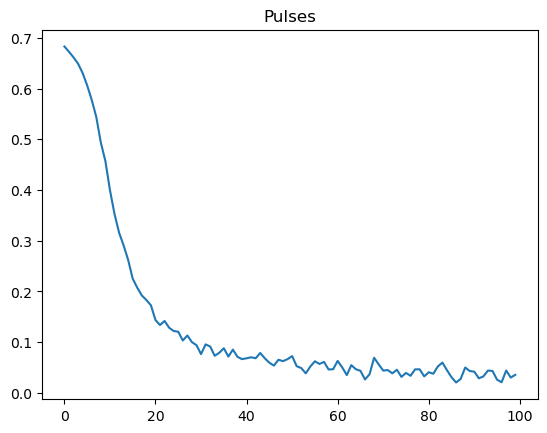

In [78]:
cnnet1.error_trace = [e.detach().numpy() for e in cnnet1.error_trace]
plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [25]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [79]:
Classes, _ = cnnet1.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
print(f'Train accuracy percent to beat: {dataBalance[-1]:.2f}')
confusion_matrix(Classes, Ttrain)

Train accuracy in percent correct: 98.97
Train accuracy percent to beat: 0.65


,-1,1
-1,98.724954,1.275046
1,0.806916,99.193084


In [109]:
Classes, _ = cnnet1.use(Xval)
perc_correct = 100 * np.mean(Classes == Tval)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
print(f'Test accuracy percent to beat: {dataBalance[-1]:.2f}')
confusion_matrix(Classes, Tval)

Test accuracy in percent correct: 70.99
Test accuracy percent to beat: 0.65


,-1,1
-1,78.236915,21.763085
1,36.288089,63.711911


### Part II: Discussion

It was somewhat of a struggle, however I would say that ultimately this analysis was a success. Initially I was getting results of ~50% accuracy on the test set with almost 100% accuracy on the training set, indicating significant overfitting. Getting the model to stop overfitting was a major hurdle in which multiple hyperparameter searches were performed (to no avail), reductions in epoch loops, learning rate, and alterations in network architecture were made; Including node number, layers, step, and patch size. In the end the two major additions that helped alleviate the overfitting were adding Dropout to the model and subsampling the mitochondrially localized proteins. This caused a ~20% jump in accuracy on the test set (PLEASE NOTE: Variable names for Validation and Test set should be swapped, but are the exact same size and so interchangeable). Despite the fact that we achieved ~70% accuracy on the test set, the model is still significantly overfitting by maintaining it's ~99% accuracy on the training set. Some further investigation was done in order to break this overfitting, but nothing resulting in rescuing the testing accuracy more than what is shown here in the results. This is, however, somewhat promising for future work since there is a pattern that the model is able to discern and with a shockingly high accuracy. If I were able to break the overfitting and increase the testing accuracy further the model could end up being highly effective at protein classification. 

Future work on this project will continue likely in a similar vein, but with a slightly differing data set and approach. For this analysis and project I kept the data sets similar (IE, using DNA), however for classification there is a much more effective way of organizing your data for a CNN that maintains more information than just nucleotide bases. Instead of DNA, I would use protein transcripts that include amino acids (encoded by every 3 base pairs). Amino acids are an interesting choice for ML model prediction with some caveats to consider. By doing this you are effectively expanding the demensions of your data to 20 (instead of 4) this can be undesireable which can result in data sparsity, however you can collapse the dimensionality of your data back down by using amino acid subgroups as your features rather than the amino acids themselves. Many amino acids share similar properties, such as being hydrophilic or hydrophobic, positively charged or negatively charged. By building a feature matrix out of the properties of amino acids you can instead test on these amino acid subgroups where the model can look for patterns of *properties* instead of patterns of *name.* In the realm of bioinformatics this is generally considered the better approach. 

When compared to my original analyses of this data from CS345 and using perceptron, SVM, and randomForest, the 1D CNN was unable to beat the performance of a well tuned randomForest. That being said, I am unsure if the results are directly comparable, because even though the gene sets were the same (Arabidopsis thaliana), the data sets and how the data was presented to the models was different. I would like to continue this project beyond the scope of this class and do some more direct comparisons / tunining of the CNN models used here. Additionally I would like to try and compare a 1D CNN Vs. a 2D CNN for this data and see if that manages to handle the data any better. 